# K-th Nearest Neighbor Density Estimation for Dataset Distribution Matching

This notebook implements KNN Density Estimation using FAISS to select samples from dataset B that follow the same distribution as dataset A. This enables us to build a model that can classify dataset A based on the selected subset of dataset B.

## 1. Required Libraries

Let's first import all the libraries we'll need.

In [134]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import faiss
import mpmath
from scipy.special import gamma, loggamma
from sklearn.preprocessing import normalize
from tqdm.notebook import tqdm
import os
import sys
# Set random seed for reproducibility
np.random.seed(42)

## 2. Implementation of KNN Density Estimation

Here we implement the KNN density estimation as described in the reference document.

In [105]:
def knn_density(x, X, k, d):
    """
    Vanilla implementation of KNN density estimation.
    
    Parameters:
    -----------
    x: point where we want to estimate density (array-like)
    X: dataset (array-like)
    k: number of neighbors
    d: dimensionality of the data
    
    Returns:
    --------
    density: estimated density at point x
    """
    # Calculate distances from point x to all points in X
    distances = np.sqrt(np.sum((X - x)**2, axis=1))
    
    # Find k-th nearest distance
    kth_distance = np.sort(distances)[k]
    
    # Add a small epsilon to prevent zero distances
    kth_distance = max(kth_distance, 1e-10)
    
    # Calculate volume of d-dimensional ball with radius kth_distance
    volume = (np.pi**(d/2) / mpmath.gamma(d/2 + 1)) * (kth_distance**d)
    
    # Compute density estimate
    density = k / (len(X) * volume)
    
    return density

## 3. FAISS Implementation for Efficient KNN Density Estimation

Using FAISS for efficient nearest neighbor search in high dimensional spaces.

In [168]:
def faiss_knn_density(query_vectors, reference_vectors, k, d, normalize_vectors=True):
    """
    Efficient implementation of KNN density estimation using FAISS.
    
    Parameters:
    -----------
    query_vectors: points where we want to estimate density (array-like, shape [n_queries, d])
    reference_vectors: dataset for density estimation (array-like, shape [n_references, d])
    k: number of neighbors
    d: dimensionality of the data
    normalize_vectors: whether to normalize vectors before computation
    
    Returns:
    --------
    densities: estimated density at each query point
    """
    # Make sure inputs are numpy arrays with float32 type (required by FAISS)
    query_vectors = np.array(query_vectors, dtype=np.float32)
    reference_vectors = np.array(reference_vectors, dtype=np.float32)
    
    # Normalize vectors if required (for cosine similarity)
    if normalize_vectors:
        query_vectors = normalize(query_vectors, axis=1)
        reference_vectors = normalize(reference_vectors, axis=1)
    
    # Get number of samples in reference set
    n = reference_vectors.shape[0]
    
    # Make sure k is not larger than n
    if k >= n:
        print(f"Warning: k ({k}) is >= number of reference points ({n}). Setting k = {n-1}")
        k = n-1
    
    # Build FAISS index
    res = faiss.StandardGpuResources() 
    index = faiss.IndexFlatL2(d)  # L2 distance (Euclidean)
    gpu_index_flat = faiss.index_cpu_to_gpu(res, 0, index)
    gpu_index_flat.add(reference_vectors)
    
    # Search for k+1 neighbors (because FAISS can include the point itself)
    distances, _ = gpu_index_flat.search(query_vectors, k+1)
    
    # Extract k-th distance for each query point
    kth_distances = distances[:, k]
    
    volumes_log = (n/2) * np.log(np.pi) + n * np.log(kth_distances) - loggamma(n/2 + 1)
    
    density_log = np.log(k) - np.log(n) - volumes_log
    
    return distances, density_log, volumes_log

In [77]:
np.pi**(300/2)

3.7366369506990834e+74

In [81]:
(np.pi**(320/2) / gamma(320/2 + 1)) * 1.2226559

9.074603081211878e-206

In [90]:
gamma(384/2 + 1)

inf

In [91]:
384/2 + 1

193.0

In [82]:
def stirling_approximation(z):
    return np.sqrt(2 * np.pi) * (z ** (z - 0.5)) * np.exp(-z)

In [93]:
import numpy as np
from scipy.special import loggamma

def log_hypersphere_volume(n, R):
    return (n/2) * np.log(np.pi) + n * np.log(R) - loggamma(n/2 + 1)

In [126]:
def log_hypersphere_volume(n, R):
    # Calculate log(V) using Stirling's approximation for large n
    n_half = n/2
    log_gamma = mpmath .log(mpmath.gamma(n_half + 1))
    log_volume = n_half * mpmath.log(mpmath.pi) + n * mpmath.log(R) - log_gamma
    return log_volume

In [128]:
dimension = 384
radius = 1
log_hypersphere_volume(dimension, radius)

-601.199093592853

In [97]:
log_hypersphere_volume(2, 1.2226559)

1.546780805446538

In [94]:
(np.pi**(320/2) / gamma(320/2 + 1)) * 1.2226559

9.074603081211878e-206

In [122]:
(np.pi**(384/2) / mpmath.gamma(384/2 + 1)) * 1.2226559**384

2.6753605931475e-228

## 4. Loading and Preparing Datasets

Let's load our datasets A and B. The dataset A contains sentences we don't know how to classify, and dataset B contains sentences we know how to classify.

In [49]:
# This is a placeholder - replace with your actual data loading code
# Let's assume we have embeddings for both datasets

# Option 1: Load pre-computed embeddings if available
try:
    embeddings_A = np.load('../embeddings/embeddings_set_A.npy')  # Dataset A embeddings
    embeddings_B = np.load('../embeddings/embeddings_set_B.npy')  # Dataset B embeddings
    print(f"Loaded embeddings A: {embeddings_A.shape}, embeddings B: {embeddings_B.shape}")
except FileNotFoundError:
    print("Embeddings files not found. Will need to compute them.")
    embeddings_A = None
    embeddings_B = None

Loaded embeddings A: (1021221, 384), embeddings B: (250951, 384)


## 5. Computing Density Estimation

Now we'll compute the density estimates for dataset B with respect to dataset A.

Embedding dimension: 384
Computing density estimates for dataset B...


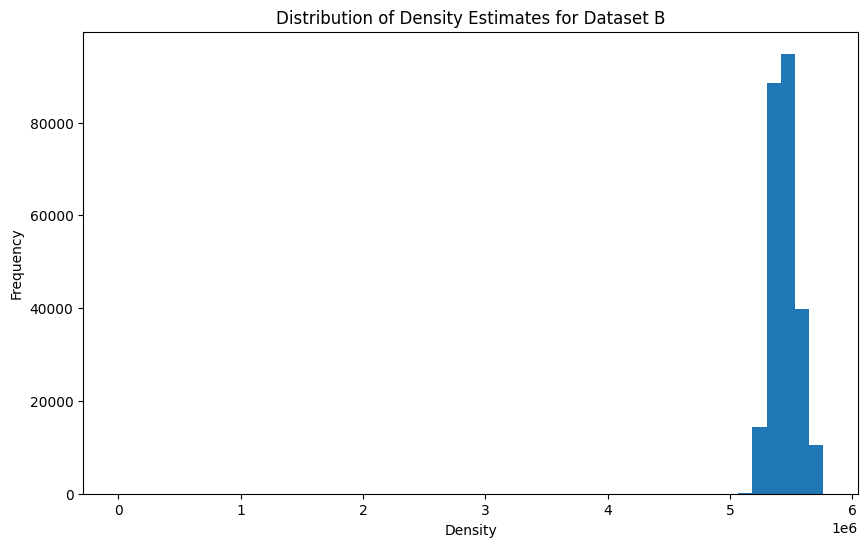

In [169]:
# Define parameters
k = 100  # Number of neighbors
d = None  # Will be set based on embeddings dimension

# Proceed if we have the embeddings
if embeddings_A is not None and embeddings_B is not None:
    # Check for NaN or Inf values in embeddings
    if np.any(~np.isfinite(embeddings_A)):
        print("Warning: Non-finite values found in embeddings_A. Replacing with zeros.")
        embeddings_A = np.nan_to_num(embeddings_A)
        
    if np.any(~np.isfinite(embeddings_B)):
        print("Warning: Non-finite values found in embeddings_B. Replacing with zeros.")
        embeddings_B = np.nan_to_num(embeddings_B)
    
    # Get dimensions
    d = embeddings_A.shape[1]
    print(f"Embedding dimension: {d}")
    
    # Estimate density of dataset B with respect to dataset A
    print("Computing density estimates for dataset B...")
    try:
        distances, densities, volumes = faiss_knn_density(embeddings_B, embeddings_A, k, d)
        
        # Let's examine the distribution of densities
        plt.figure(figsize=(10, 6))
        plt.hist(densities, bins=50, range=(0, np.percentile(densities, 99)))
        plt.title('Distribution of Density Estimates for Dataset B')
        plt.xlabel('Density')
        plt.ylabel('Frequency')
        plt.show()
    except Exception as e:
        print(f"Error computing densities: {e}")

## 6. Selecting Best Samples from Dataset B

Let's select samples from dataset B that have the highest density with respect to dataset A's distribution.

In [170]:
distances[:, k]  # Display distances to k nearest neighbors

array([1.2226559, 1.1223094, 1.1990544, ..., 1.1530682, 1.0991852,
       1.2400087], dtype=float32)

In [171]:
volumes

array([-5410733.29384506, -5498187.47813395, -5430639.20783854, ...,
       -5470575.89441802, -5519448.65948631, -5396341.27529738])

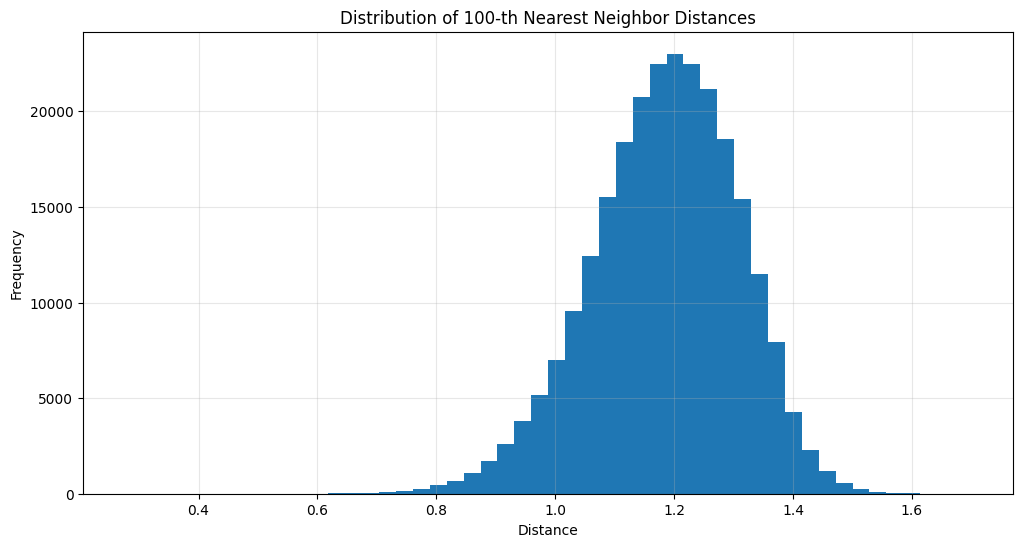

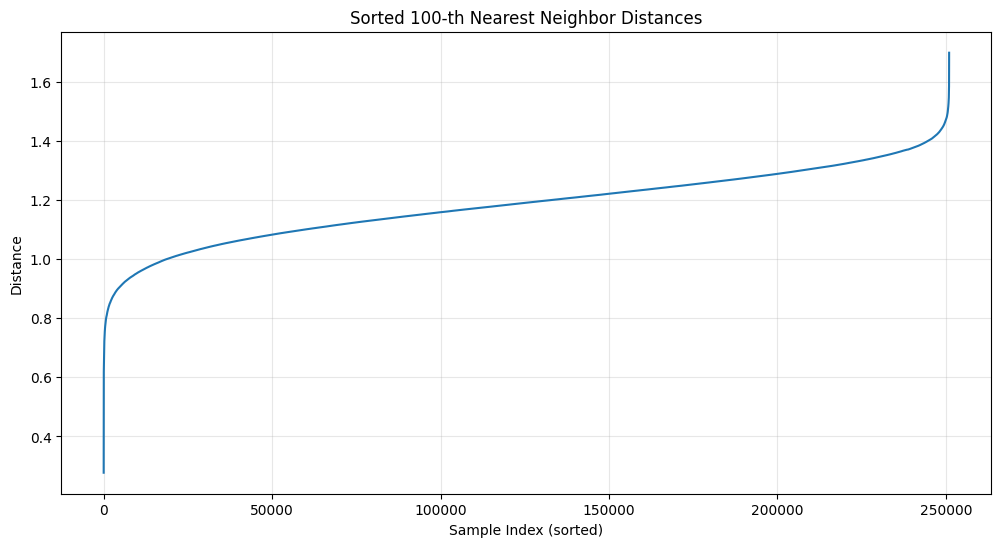

Min distance: 0.277037
Max distance: 1.699166
Mean distance: 1.184232
Median distance: 1.191319
Std dev of distances: 0.122931


In [172]:
# Plot the k-th distances
plt.figure(figsize=(12, 6))
plt.hist(distances[:, k], bins=50)
plt.title(f'Distribution of {k}-th Nearest Neighbor Distances')
plt.xlabel('Distance')
plt.ylabel('Frequency')
plt.grid(alpha=0.3)
plt.show()

# You can also visualize using a sorted plot to see the distribution more clearly
plt.figure(figsize=(12, 6))
sorted_distances = np.sort(distances[:, k])
plt.plot(range(len(sorted_distances)), sorted_distances)
plt.title(f'Sorted {k}-th Nearest Neighbor Distances')
plt.xlabel('Sample Index (sorted)')
plt.ylabel('Distance')
plt.grid(alpha=0.3)
plt.show()

# Check statistics
print(f"Min distance: {np.min(distances[:, k]):.6f}")
print(f"Max distance: {np.max(distances[:, k]):.6f}")
print(f"Mean distance: {np.mean(distances[:, k]):.6f}")
print(f"Median distance: {np.median(distances[:, k]):.6f}")
print(f"Std dev of distances: {np.std(distances[:, k]):.6f}")

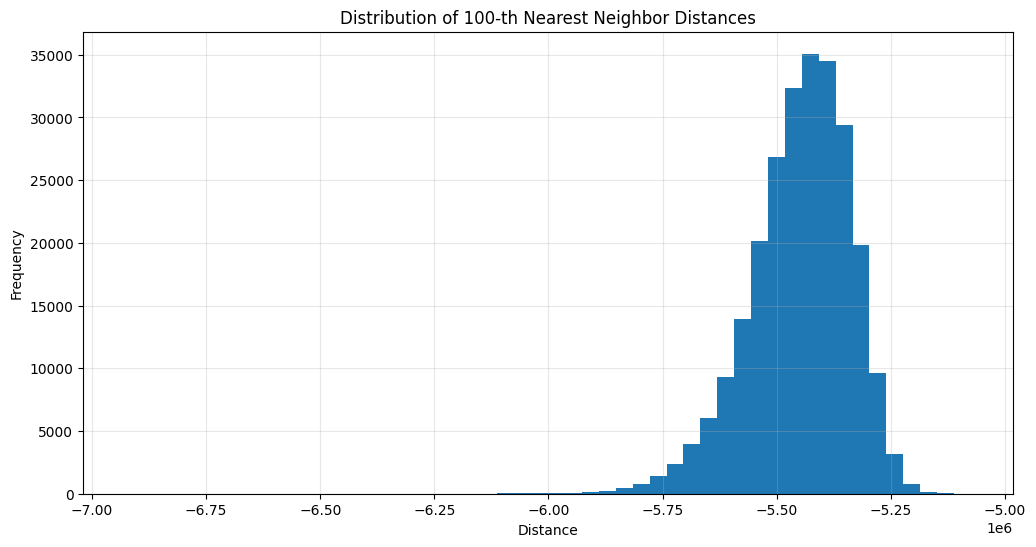

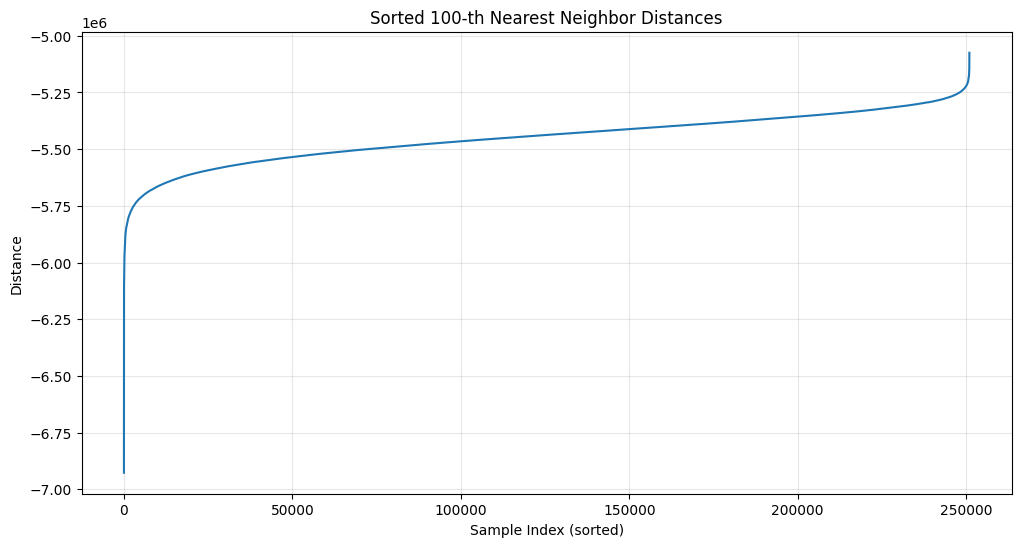

Min volume: -6926867.732897
Max volume: -5074637.123618
Mean volume: -5449093.137490
Median volume: -5437249.058901
Std dev of volume: 109806.542314


In [173]:
# Plot the volumes
plt.figure(figsize=(12, 6))
plt.hist(volumes, bins=50)
plt.title(f'Distribution of {k}-th Nearest Neighbor Distances')
plt.xlabel('Distance')
plt.ylabel('Frequency')
plt.grid(alpha=0.3)
plt.show()

# You can also visualize using a sorted plot to see the distribution more clearly
plt.figure(figsize=(12, 6))
sorted_volumes = np.sort(volumes)
plt.plot(range(len(sorted_volumes)), sorted_volumes)
plt.title(f'Sorted {k}-th Nearest Neighbor Distances')
plt.xlabel('Sample Index (sorted)')
plt.ylabel('Distance')
plt.grid(alpha=0.3)
plt.show()

# Check statistics
print(f"Min volume: {np.min(volumes):.6f}")
print(f"Max volume: {np.max(volumes):.6f}")
print(f"Mean volume: {np.mean(volumes):.6f}")
print(f"Median volume: {np.median(volumes):.6f}")
print(f"Std dev of volume: {np.std(volumes):.6f}")

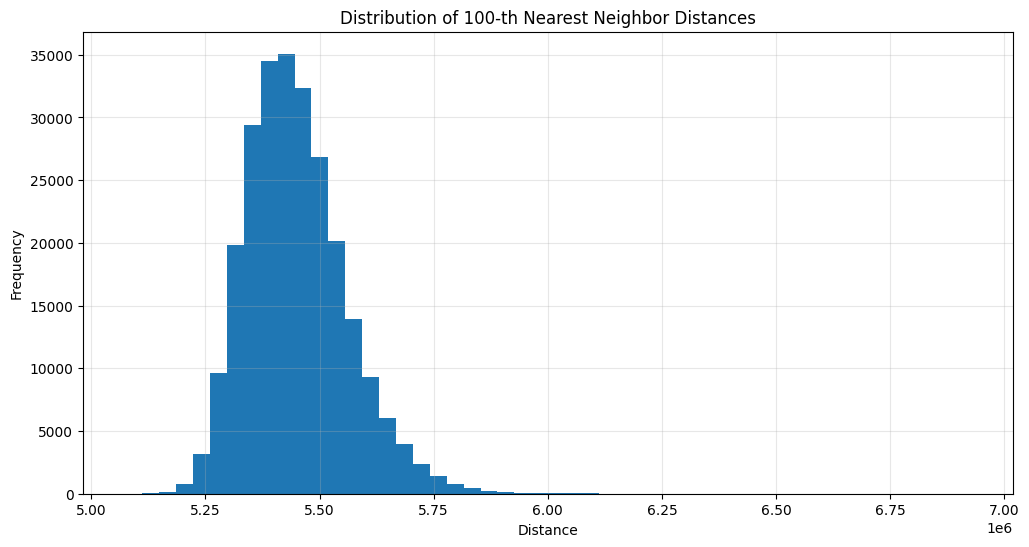

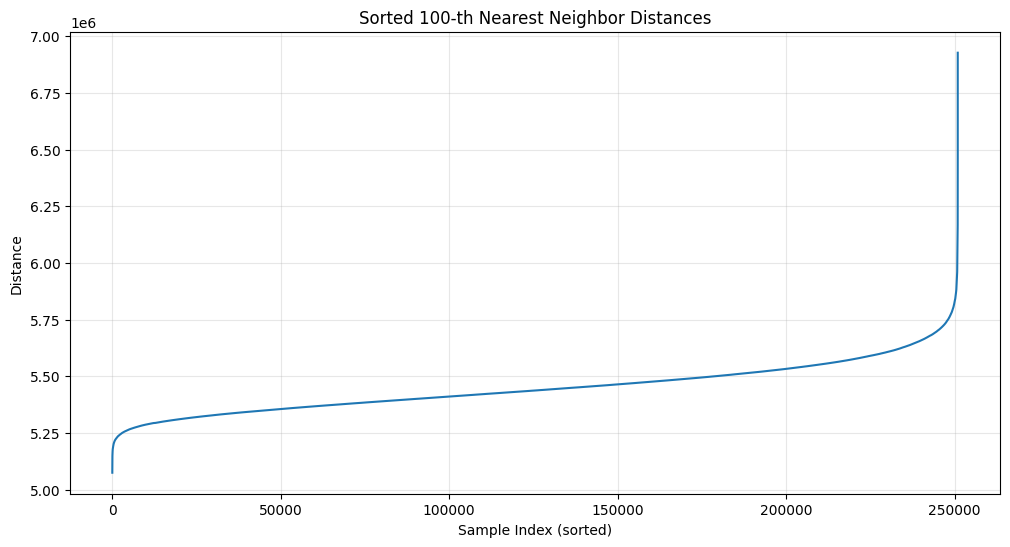

Min densities: 5074627.892278523
Max densities: 6926858.501557679
Mean densities: 5449083.906150172
Median densities: 5437239.827561528
Std dev of densities: 109806.54231365104


In [174]:
# Plot the densities
plt.figure(figsize=(12, 6))
plt.hist(densities, bins=50)
plt.title(f'Distribution of {k}-th Nearest Neighbor Distances')
plt.xlabel('Distance')
plt.ylabel('Frequency')
plt.grid(alpha=0.3)
plt.show()

# You can also visualize using a sorted plot to see the distribution more clearly
plt.figure(figsize=(12, 6))
sorted_densities = np.sort(densities)
plt.plot(range(len(sorted_densities)), sorted_densities)
plt.title(f'Sorted {k}-th Nearest Neighbor Distances')
plt.xlabel('Sample Index (sorted)')
plt.ylabel('Distance')
plt.grid(alpha=0.3)
plt.show()

# Check statistics
print(f"Min densities: {np.min(densities)}")
print(f"Max densities: {np.max(densities)}")
print(f"Mean densities: {np.mean(densities)}")
print(f"Median densities: {np.median(densities)}")
print(f"Std dev of densities: {np.std(densities)}")

In [175]:
def select_high_density_samples(densities, embeddings_B, dataset_B=None, top_k=0.01):
    """
    Select samples from dataset B that have the highest density in the distribution of dataset A.
    
    Parameters:
    -----------
    densities: density estimates for each sample in dataset B
    embeddings_B: embeddings of dataset B
    dataset_B: original dataset B (optional)
    top_k: proportion or number of samples to select
    
    Returns:
    --------
    selected_indices: indices of selected samples
    selected_embeddings: embeddings of selected samples
    selected_dataset: selected samples from original dataset (if dataset_B provided)
    """
    # Determine number of samples to select
    if top_k < 1:
        num_to_select = int(top_k * len(densities))
    else:
        num_to_select = min(int(top_k), len(densities))
    
    # Sort by density and select top num_to_select
    selected_indices = np.argsort(densities)[-num_to_select:]
    selected_embeddings = embeddings_B[selected_indices]
    
    # Also return the selected samples from the original dataset if provided
    selected_dataset = None
    if dataset_B is not None:
        selected_dataset = dataset_B.iloc[selected_indices]
    
    return selected_indices, selected_embeddings, selected_dataset

Selected 2509 samples (1.0%) with highest density


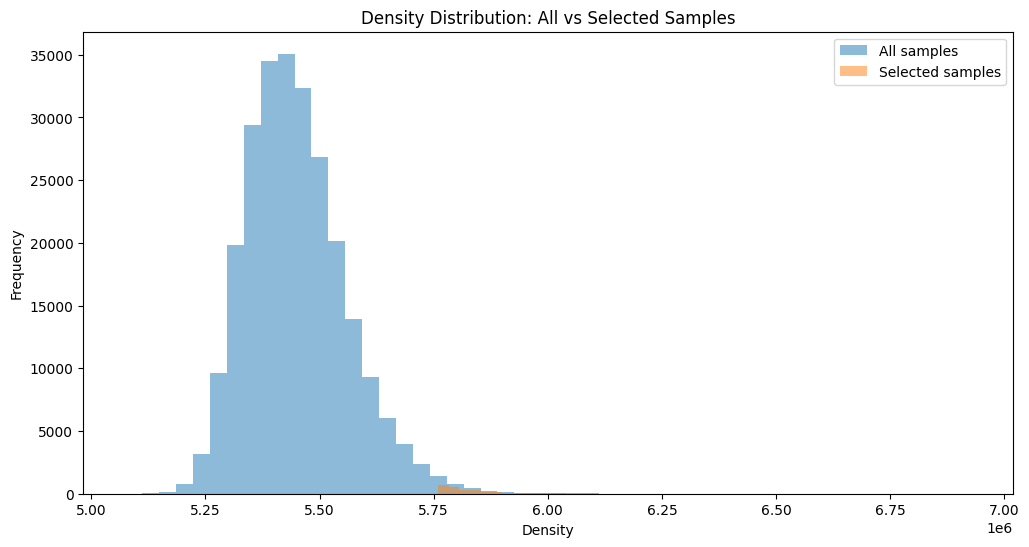

In [176]:
# Proceed if we have the density estimates
if 'densities' in locals():
    # Select top 10% of samples
    top_percentage = 0.01
    selected_indices, selected_embeddings, _ = select_high_density_samples(densities, embeddings_B, top_k=top_percentage)
    
    print(f"Selected {len(selected_indices)} samples ({top_percentage*100:.1f}%) with highest density")
    
    # Let's compare the distribution of selected vs. all samples
    plt.figure(figsize=(12, 6))
    plt.hist(densities, bins=50, alpha=0.5, label='All samples')
    plt.hist(densities[selected_indices], bins=50, alpha=0.5, label='Selected samples')
    plt.title('Density Distribution: All vs Selected Samples')
    plt.xlabel('Density')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

## 7. Validation of Selected Samples

Let's validate that the selected samples from dataset B follow the same distribution as dataset A.

In [177]:
def compute_distribution_similarity(embA, embB, method='faiss'):
    """
    Compute similarity between two distributions.
    
    Parameters:
    -----------
    embA: embeddings of dataset A
    embB: embeddings of dataset B
    method: method to compute similarity
    
    Returns:
    --------
    similarity: similarity score
    """
    if method == 'faiss':
        res = faiss.StandardGpuResources()
        # Use average nearest neighbor distance as similarity measure
        index = faiss.IndexFlatL2(embA.shape[1])
        gpu_index = faiss.index_cpu_to_gpu(res, 0, index)
        gpu_index.add(embA.astype(np.float32))
        distances, _ = gpu_index.search(embB.astype(np.float32), 1)
        return distances.mean()
    elif method == 'cosine':
        # Use average cosine similarity
        embA_norm = normalize(embA)
        embB_norm = normalize(embB)
        similarity = np.mean([np.max(embA_norm.dot(b)) for b in embB_norm])
        return similarity
    else:
        raise ValueError(f"Unknown method: {method}")

In [178]:
# Validate if we have the selected embeddings
if 'selected_embeddings' in locals():
    # Compute similarity between dataset A and selected subset of dataset B
    similarity_selected = compute_distribution_similarity(embeddings_A, selected_embeddings)
    
    # For comparison, compute similarity between dataset A and all of dataset B
    similarity_all = compute_distribution_similarity(embeddings_A, embeddings_B)
    
    print(f"Similarity between A and all B: {similarity_all:.4f}")
    print(f"Similarity between A and selected B: {similarity_selected:.4f}")
    
    # Lower distance means higher similarity
    if similarity_selected < similarity_all:
        print("✓ Selected samples are more similar to dataset A than the full dataset B")
    else:
        print("✗ Selected samples are not more similar to dataset A than the full dataset B")

Similarity between A and all B: 0.8746
Similarity between A and selected B: 0.5513
✓ Selected samples are more similar to dataset A than the full dataset B


## 8. Dimensionality Reduction for Visualization

Let's visualize the embeddings to understand the distribution.

In [179]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

def visualize_embeddings(embA, embB, embB_selected=None, method='pca', n_components=2, plot_selected=True):
    """
    Visualize embeddings using dimensionality reduction.
    
    Parameters:
    -----------
    embA: embeddings of dataset A
    embB: embeddings of dataset B
    embB_selected: embeddings of selected samples from dataset B (optional)
    method: dimensionality reduction method ('pca' or 'tsne')
    n_components: number of components for dimensionality reduction
    plot_selected: whether to plot selected samples from B (if provided)
    """
    # Combine all embeddings for dimension reduction
    all_emb = np.vstack([embA, embB])
    
    # Apply dimensionality reduction
    if method == 'pca':
        reducer = PCA(n_components=n_components)
        reduced = reducer.fit_transform(all_emb)
    elif method == 'tsne':
        reducer = TSNE(n_components=n_components, random_state=42)
        reduced = reducer.fit_transform(all_emb)
    else:
        raise ValueError(f"Unknown method: {method}")
    
    # Split back into datasets
    reduced_A = reduced[:len(embA)]
    reduced_B = reduced[len(embA):]
    
    # Create visualization
    plt.figure(figsize=(12, 10))
    plt.scatter(reduced_A[:, 0], reduced_A[:, 1], alpha=0.5, label="Dataset A")
    plt.scatter(reduced_B[:, 0], reduced_B[:, 1], alpha=0.3, label="Dataset B")
    
    # If we have selected samples and plot_selected is True, show them too
    if embB_selected is not None and plot_selected:
        # Apply same transformation to selected samples
        if method == 'pca':
            reduced_selected = reducer.transform(embB_selected)
        else:  # For t-SNE, we need to refit
            combined = np.vstack([all_emb, embB_selected])
            combined_reduced = reducer.fit_transform(combined)
            reduced_selected = combined_reduced[len(all_emb):]
        
        plt.scatter(reduced_selected[:, 0], reduced_selected[:, 1], 
                   color='red', marker='x', s=100, label="Selected B")
    
    plt.title(f"Embedding Visualization using {method.upper()}")
    plt.legend()
    plt.show()

Visualizing embeddings using PCA with selected samples...


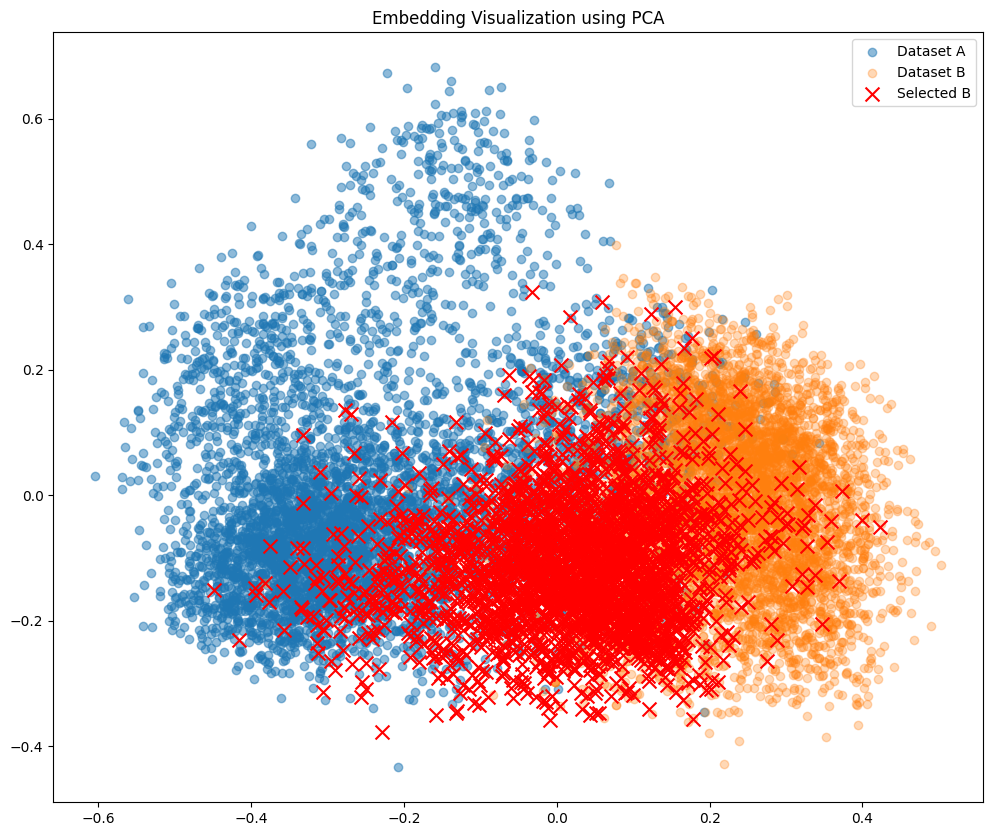

Visualizing embeddings using PCA without selected samples...


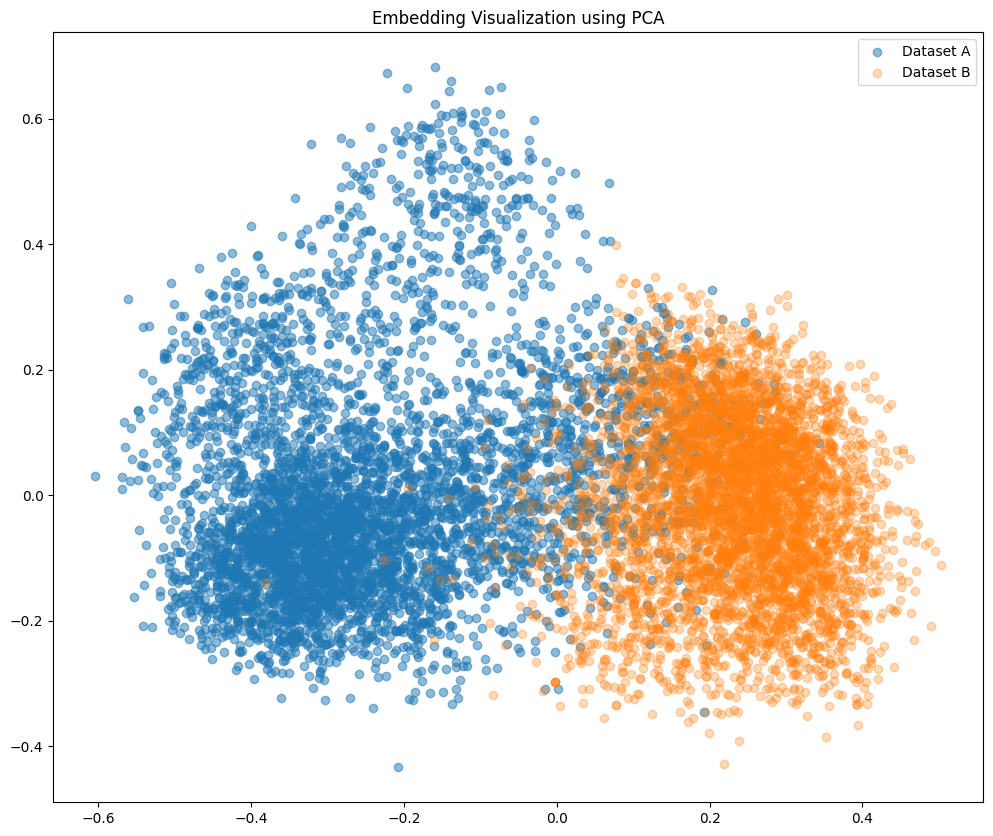

Visualizing embeddings using t-SNE with selected samples...


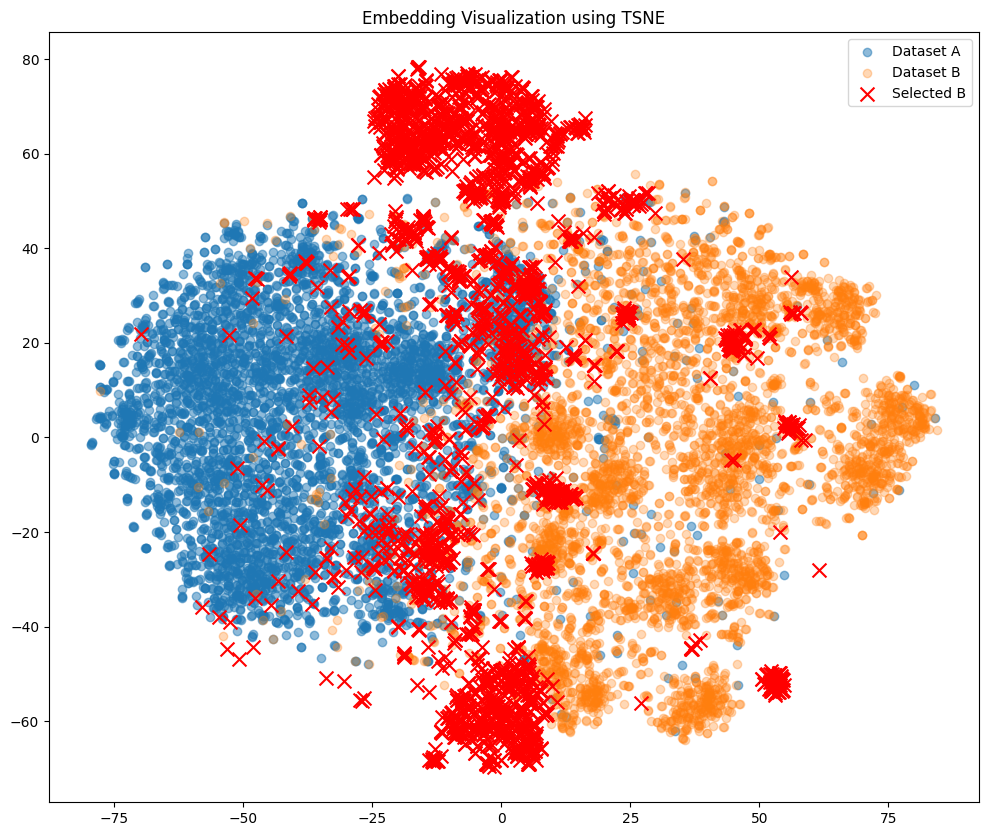

Visualizing embeddings using t-SNE without selected samples...


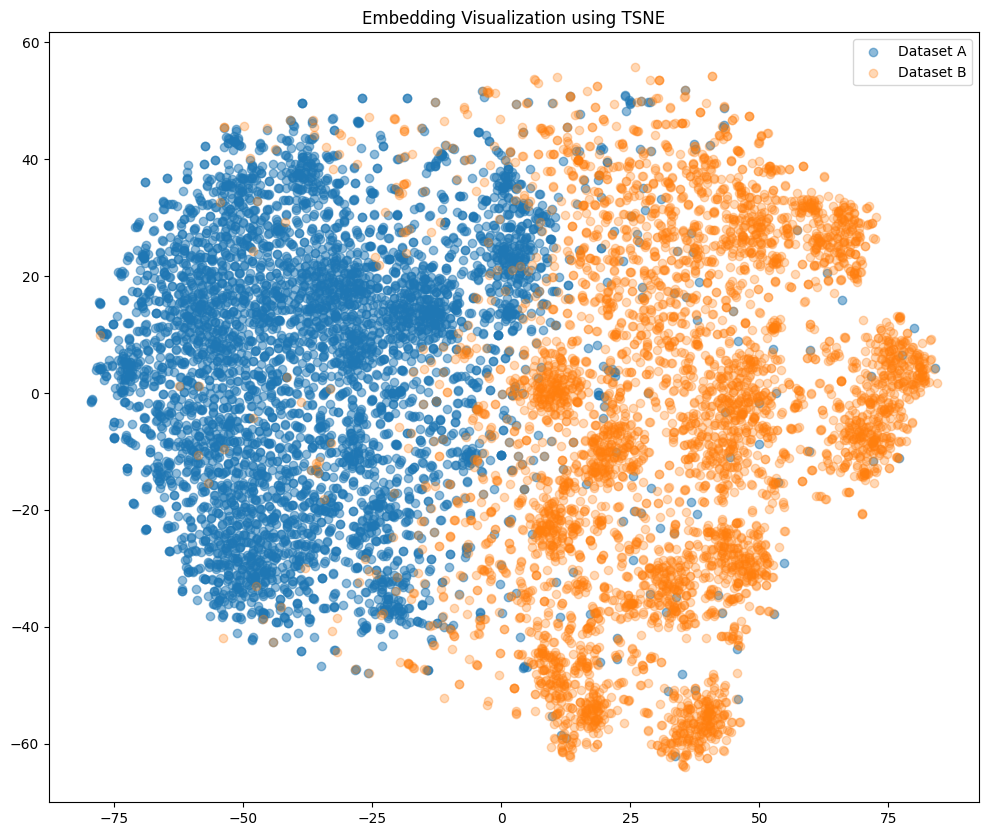

In [180]:
# Visualize if we have the embeddings
if 'selected_embeddings' in locals():
    # For large datasets, sample to make visualization faster
    max_points = 5000
    
    if len(embeddings_A) > max_points:
        idx_A = np.random.choice(len(embeddings_A), max_points, replace=False)
        embA_vis = embeddings_A[idx_A]
    else:
        embA_vis = embeddings_A
        
    if len(embeddings_B) > max_points:
        idx_B = np.random.choice(len(embeddings_B), max_points, replace=False)
        embB_vis = embeddings_B[idx_B]
    else:
        embB_vis = embeddings_B
    
    # Visualize using PCA with selected samples
    print("Visualizing embeddings using PCA with selected samples...")
    visualize_embeddings(embA_vis, embB_vis, selected_embeddings, method='pca', plot_selected=True)
    
    # Visualize using PCA without selected samples
    print("Visualizing embeddings using PCA without selected samples...")
    visualize_embeddings(embA_vis, embB_vis, method='pca', plot_selected=False)
    
    # Visualize using t-SNE with selected samples
    print("Visualizing embeddings using t-SNE with selected samples...")
    visualize_embeddings(embA_vis, embB_vis, selected_embeddings, method='tsne', plot_selected=True)
    
    # Visualize using t-SNE without selected samples
    print("Visualizing embeddings using t-SNE without selected samples...")
    visualize_embeddings(embA_vis, embB_vis, method='tsne', plot_selected=False)

In [181]:
selected_embeddings.shape

(2509, 384)

## 9. Saving Selected Samples

Let's save the selected samples for future use.

In [ ]:
# Save selected indices, embeddings, and samples if available
if 'selected_indices' in locals():
    # Create output directory if it doesn't exist
    os.makedirs('../embeddings', exist_ok=True)
    
    # Save indices of selected samples
    np.save('../embeddings/selected_indices.npy', selected_indices)
    print(f"Saved selected indices to ../embeddings/selected_indices.npy")
    
    # Save embeddings of selected samples
    np.save('../embeddings/selected_embeddings.npy', selected_embeddings)
    print(f"Saved selected embeddings to ../embeddings/selected_embeddings.npy")
    
    # If we have the original dataset B, save the selected samples
    if 'dataset_B' in locals() and dataset_B is not None:
        selected_dataset = dataset_B.iloc[selected_indices]
        selected_dataset.to_csv('../new_data/selected_samples.csv', index=False)
        print(f"Saved selected samples to ../new_data/selected_samples.csv")

## 10. Summary and Conclusion

In this notebook, we have:

1. Implemented KNN Density Estimation using FAISS for efficient nearest neighbor search
2. Loaded embeddings for datasets A and B
3. Computed density estimates for dataset B with respect to dataset A's distribution
4. Selected samples from dataset B that have the highest density (most similar to dataset A)
5. Validated that the selected samples follow a distribution similar to dataset A
6. Visualized the embeddings to understand the distribution of the datasets
7. Saved the selected samples for future use

The selected samples from dataset B can now be used to build a model that can classify dataset A, as they follow a similar distribution.

## 11. Next Steps

Potential next steps include:

1. Train a classifier on the selected samples from dataset B
2. Apply the classifier to dataset A
3. Evaluate the performance of the classifier
4. Experiment with different values of k for KNN density estimation
5. Try different methods for selecting samples (e.g., based on percentiles of density)